下面开始构架数据集

In [86]:
import torch.utils.data as data
import pandas as pd
import os
import image_utils
import cv2
from torchvision import transforms
import torch
import random
import torchvision
from IPython.display import display
from einops.layers.torch import Rearrange
from torch import nn
import torch
from torchvision import transforms
pil=torchvision.transforms.ToPILImage()#将tensor数据转换成图片

class RAFDB(data.Dataset):
    def __init__(self,phase="train",transform=None,basic_aug=True):
        self.phase=phase
        self.transform=transform
        self.basic_aug=basic_aug
        
        NAME_COLUMN=0 #图片名字
        LABEL_COLUMN=1 #图片标签

        df=pd.read_csv("E:/desktop/WY/MY/15/datasets/raf-basic/EmoLabel/list_patition_label.txt",sep=' ',header=None)
        if phase=="train":
            dataset=df[df[NAME_COLUMN].str.startswith('train')]
        else:
            dataset=df[df[NAME_COLUMN].str.startswith('test')]
        file_names=dataset.iloc[:,NAME_COLUMN].values    #所有行获得第一列的文件名字
        self.label=dataset.iloc[:,LABEL_COLUMN].values-1 #  0:Surprise, 1:Fear, 2:Disgust, 3:Happiness, 4:Sadness, 5:Anger, 6:Neutral

        self.file_paths=[]#使用对齐过的图片进行训练、测试

        for f in file_names:
            f=f.split(".")[0] #只要文件名字，不要后缀名
            f=f+"_aligned.jpg" #使用对齐后的图片
            path=os.path.join('E:/desktop/WY/MY/15/datasets/raf-basic/Image/aligned',f)
            self.file_paths.append(path)

        self.aug_func=[image_utils.flip_image,image_utils.add_gaussian_noise]

    def __len__(self):
        return len(self.file_paths)   #返回一共有多少张图片

    def __getitem__(self,idx):   
        path=self.file_paths[idx]
        image=cv2.imread(path)
        image = image[:, :, ::-1]  #读取该张图片并将其转换为RGB格式，原格式为#BGR
        label=self.label[idx]  #得到该张图片对应的标签

        #如果是训练阶段，就对图片进行随机增强
        if self.phase=="train":
            if self.basic_aug and random.uniform(0,1)>0.5:
                #即如果basic_aug为真并且随机数大于0.5，就对该张图片进行随机增强
                index=random.randint(0,1) #随机取0或者取1
                image=self.aug_func[index](image) #取增强中的随机一种方法进行图片增强

            #然后再对图片进行预处理
        if self.transform is not None:
            #一系列变换，根据均值标准差进行归一化,随机翻转、随机遮挡
            image=self.transform(image)

        return image,label,idx   #返回处理过后的图片数据、图片标签以及图片对应的位置


测试数据集是否正确


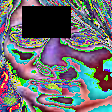

In [87]:
train_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((112, 112)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
            transforms.RandomErasing(scale=(0.02,0.25))])
train_dataset=RAFDB(phase='train',transform=train_transforms,basic_aug=True)
display(pil(train_dataset.__getitem__(0)[0]))


下面构建IR-50

In [ ]:
class IR_50(nn.Module):
    def __init__(self):
        super().__init__()
        self.stage0=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=(3,3),stride=1,padding=1),
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=(3,3),stride=1,padding=1),
            nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0) 
        )
        self.stage1=nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3),stride=1,padding=1),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(3,3),stride=1,padding=1),
            nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0) 
        )
        self.stage2=nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),stride=1,padding=1),
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=(3,3),stride=1,padding=1),
            nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0) 
        )

    def forward(self,input):
        output=self.stage0(input)
        output=self.stage1(output)
        output=self.stage2(output)
        return output

构建LocalCNNs

In [ ]:
class LocalCNN(nn.Module):
    def __init__(self):
        